# Compare Retrieval Heatmaps

Generate retrieval score heatmaps for a base model and its blocked variants.

In [22]:
import json
import glob
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


In [23]:
# Base configuration. Update `base_model_name` to visualize a different set.
base_model_name = "llada_block_top"
results_root = os.path.join("..", "results", "graph","exp_2")

variants = {
    "Base": base_model_name,
    "Block Random 30": f"{base_model_name}_block_random30",
    "Block Top 30": f"{base_model_name}_block_top30",
}

sns.set_theme(style="whitegrid")
HEATMAP_CMAP = LinearSegmentedColormap.from_list(
    "retrieval_cmap", ["#F0496E", "#EBB839", "#0CD79F"]
)


In [24]:
def load_results(model_key: str) -> pd.DataFrame:
    """Load scored retrieval results for a specific model variant."""
    folder_path = os.path.join(results_root, model_key)
    if not os.path.isdir(folder_path):
        raise FileNotFoundError(f"Results folder not found: {folder_path}")

    records = []
    for file_path in glob.glob(os.path.join(folder_path, "*.json")):
        with open(file_path, "r") as f:
            sample = json.load(f)

        records.append({
            "Document Depth": sample.get("depth_percent"),
            "Context Length": sample.get("context_length"),
            "Score": sample.get("score"),
        })

    df = pd.DataFrame(records)
    if df.empty:
        raise ValueError(f"No score data found in {folder_path}")

    df = df.dropna(subset=["Document Depth", "Context Length", "Score"])
    df["Document Depth"] = df["Document Depth"].astype(float)
    df["Context Length"] = df["Context Length"].astype(int)

    return df


def pivot_scores(df: pd.DataFrame) -> pd.DataFrame:
    """Aggregate scores by depth and context length."""
    pivot = (
        df.groupby(["Document Depth", "Context Length"])["Score"]
        .mean()
        .reset_index()
        .pivot(index="Document Depth", columns="Context Length", values="Score")
        .sort_index()
        .sort_index(axis=1)
    )
    return pivot


def build_heatmap(
    pivot: pd.DataFrame, title: str, ax: plt.Axes, show_ylabel: bool = True, show_colorbar: bool = True
) -> None:
    """Render a heatmap for the aggregated scores."""
    sns.heatmap(
        pivot,
        cmap=HEATMAP_CMAP,
        cbar=show_colorbar,
        cbar_kws={"label": "Score"},
        vmin=0,
        vmax=100,
        ax=ax,
    )
    ax.set_title(title)
    ax.set_xlabel("Context Length")
    if show_ylabel:
        ax.set_ylabel("Depth Percent")
        ax.tick_params(axis="y", labelleft=True, rotation=0)
    else:
        ax.set_ylabel("")
        ax.tick_params(axis="y", labelleft=False, rotation=0)
    ax.tick_params(axis="x", rotation=45)


Base: 790 rows -> heatmap shape (10, 79)
Block Random 30: 790 rows -> heatmap shape (10, 79)
Block Top 30: 790 rows -> heatmap shape (10, 79)


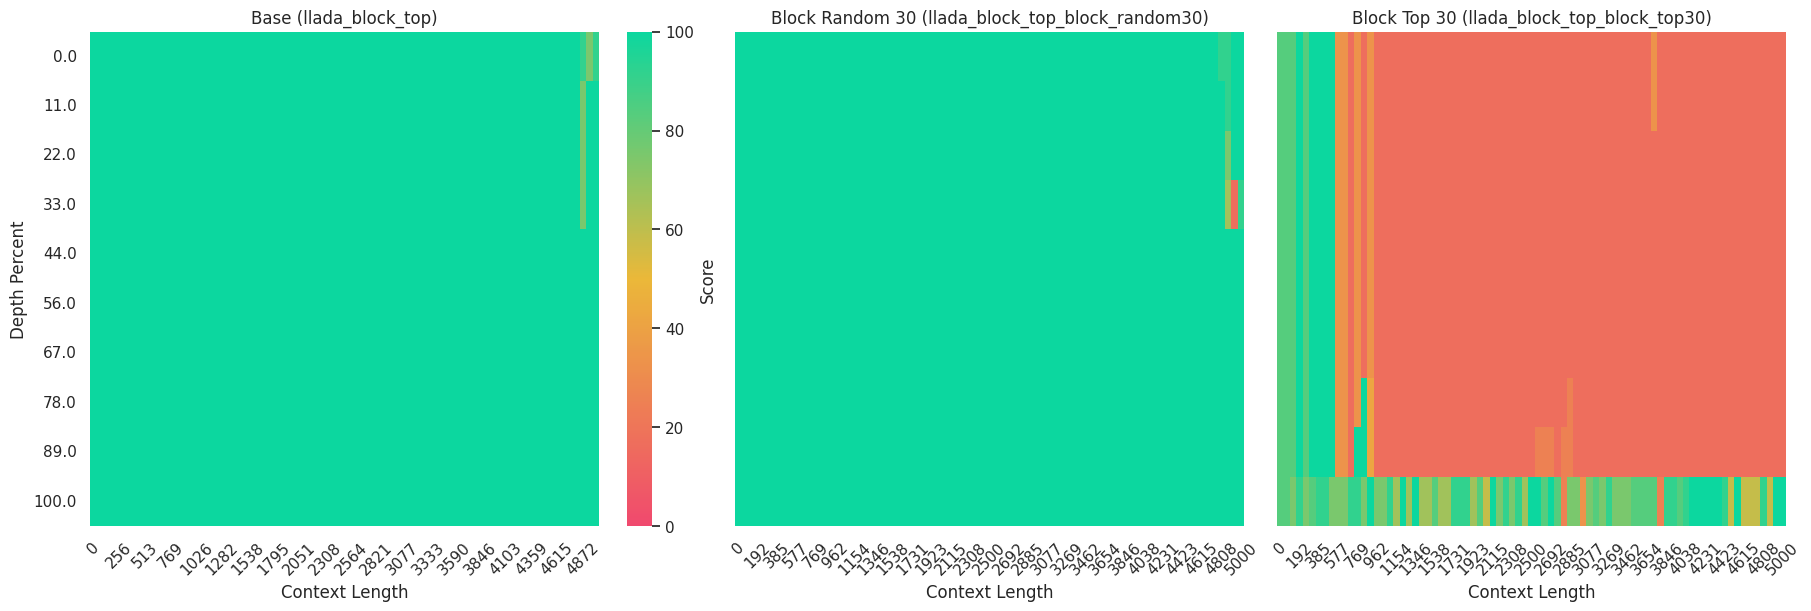

In [27]:
fig, axes = plt.subplots(
    1, len(variants), figsize=(18, 6), sharey=True, constrained_layout=True
)

if hasattr(axes, "flatten"):
    axes = axes.flatten().tolist()
else:
    axes = [axes]

for idx, (ax, (label, model_key)) in enumerate(zip(axes, variants.items())):
    df = load_results(model_key)
    pivot = pivot_scores(df)
    print(f"{label}: {len(df)} rows -> heatmap shape {pivot.shape}")
    build_heatmap(
        pivot, f"{label} ({model_key})", ax, show_ylabel=(idx == 0), show_colorbar=(idx == 0)
    )

plt.show()
